In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [3]:
SD = 0.05 * (0.8 ** 7) # -4 ... 10 
print('SD:', SD)

SD: 0.010485760000000004


In [4]:
DATA = '../models/qp/data'
SYMBOLS = [
    'ABMD', 'ABNB', 'AMZN', 'ANET', 'APPH', 'ATVI', 'AXON', 'AYX', 
    'BILI', 'BYND', 'COUR','CPNG', 'DDOG', 'DOCU', 'DUOL', 'EDIT', 
    'ELIO', 'ETSY', 'FSLY', 'FUV', 'GH', 'GMED', 'INTG', 'ISRG', 'JD', 
    'LULU', 'LUV', 'MDB', 'MELI', 'MNST', 'MTCH', 'NVCR', 'OKTA', 
    'PANW', 'PINS', 'PTON', 'QDEL', 'RDFN', 'RGEN', 'ROKU', 'SE', 
    'SHOP', 'SPLK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO', 
    'TWTR', 'UPST', 'VEEV', 'ZEN', 'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

55

In [5]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = '1978-07-26' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1978-07-26', datetime.date(2021, 9, 10))

In [6]:
batcher = Batcher(SYMBOLS, INDICES)
batch = batcher.get_batch_from_weekday(TODAY.weekday())
batch

['TEAM',
 'TREX',
 'TTD',
 'TTWO',
 'TWLO',
 'TWTR',
 'UPST',
 'VEEV',
 'ZEN',
 'ZG',
 'ZNGA',
 '^IXIC']

In [7]:
stock_loader = Loader(batch, START, verbose=True)
data = stock_loader.download()

[*********************100%***********************]  12 of 12 completed
Generating derived columns...
   ...TEAM
   ...TREX
   ...TTD
   ...TTWO
   ...TWLO
   ...TWTR
   ...UPST
   ...VEEV
   ...ZEN
   ...ZG
   ...ZNGA
   ...^IXIC


In [8]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [9]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [10]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [11]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [12]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [13]:
if TODAY.weekday() == 0:
    !say update standard deviation




----------------------------------------------------------------------
                                 TEAM
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 13.5660983752697
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 13.5660983752697
Refitting current best...
Current best ew_ma returns: 17.324651084316606
Fraction Invested: 0.04670809038459943
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 17.285799819443366
Invested: 0.04670809038459943
New best: 17.28758352327833
Invested: 0.03805824197364429
New best: 17.28698069615263
Invested: 0.03805824197364429
New best: 17.229906518357033
Invested: 0.03805824197364429
New best: 17.254463049099634
Inv

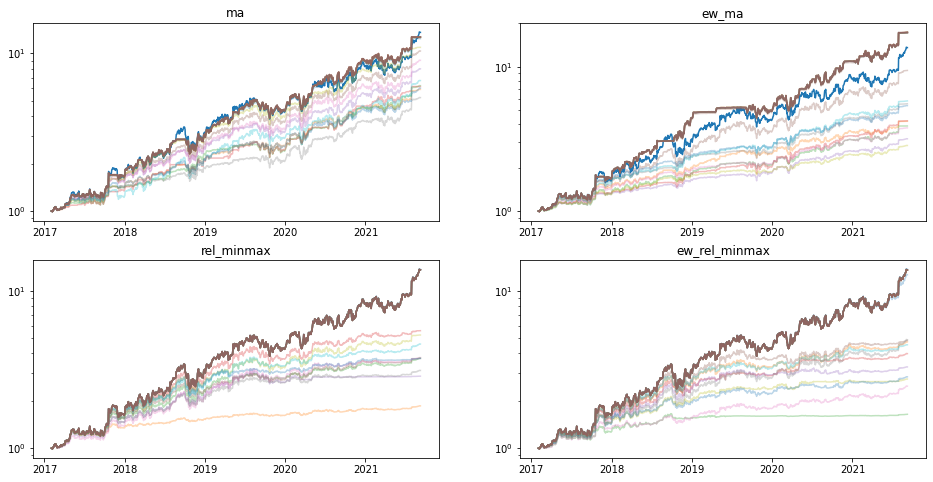

Saving TEAM params...



----------------------------------------------------------------------
                                 TREX
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 28.047678691439145
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 28.28974321778146
Invested: 0.24782911655136697
New best: 28.300982150783412
Invested: 0.24782911655136697
New best: 28.29775722646652
Invested: 0.24782911655136697
New best: 28.31384103004696
Invested: 0.24782911655136697
New best: 28.72716759076269
Invested: 0.24782911655136697
New best: 28.72716759076269
Invested: 0.24782911655136697
New best: 28.765417753254532
Invested: 0.24782911655136697
New best: 28.789513420681164
Invested: 0.24782911655136697
New best: 28.774701625727097
Invested: 0.24782911655136697
New best: 28.6124737

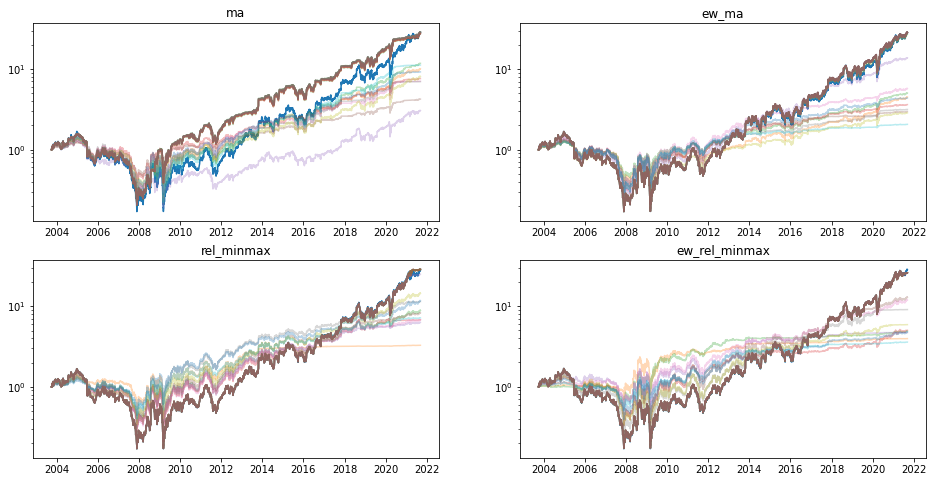

Saving TREX params...



----------------------------------------------------------------------
                                 TTD
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 11.714193755040126
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 11.714193755040126
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 11.714193755040126
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 11.930825413948451
Invested: 0.14284074596166635
N

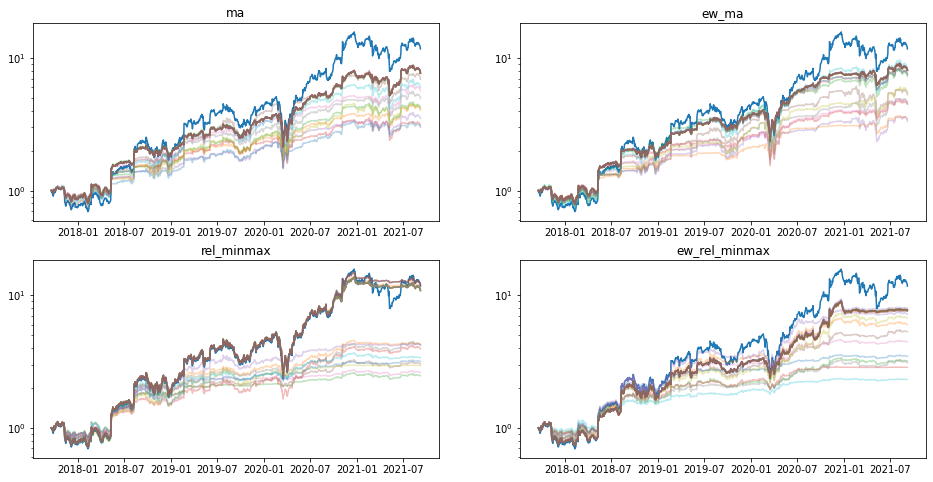

Saving TTD params...



----------------------------------------------------------------------
                                 TTWO
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 12.483808872153425
Refitting current best...
Current best ma returns: 13.861235826720101
Fraction Invested: 0.9977492500236123
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 13.861235826720101
Invested: 0.9977492500236123
New best: 13.920604844905396
Invested: 0.9977492500236123
New best: 13.927464135345849
Invested: 0.9977492500236123
New best: 13.930592500731004
Invested: 0.9977492500236123
New best: 13.930412223580378
Invested: 0.9977492500236123
New best: 13.935886040949976
Invested: 0.9977492500236123
New best: 13.930528644676794
Invested: 0.9977492500236123
New best: 13.929852086651074
Invested: 0.9977492500236123
New best: 13.929510072

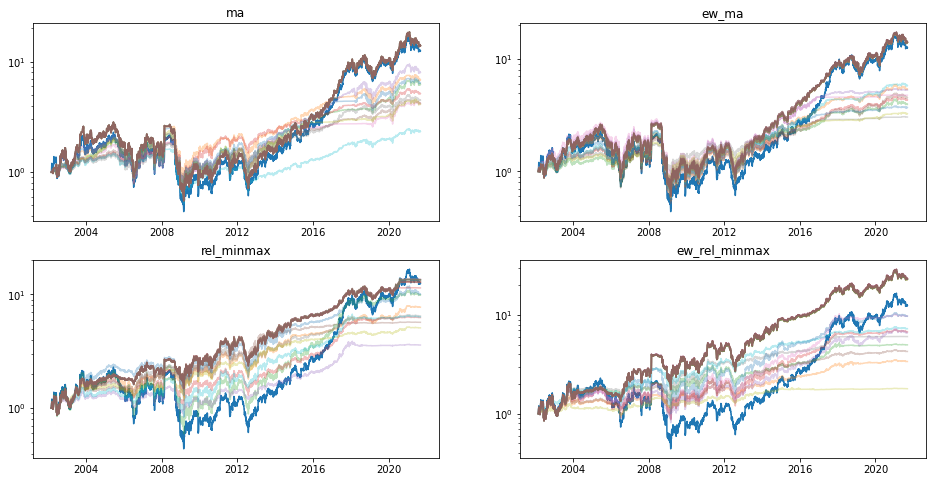

Saving TTWO params...



----------------------------------------------------------------------
                                 TWLO
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 12.268173615828804
Refitting current best...
Current best ma returns: 12.978586528937171
Fraction Invested: 0.9987440809069159
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 12.979948255418245
Invested: 0.9987440809069159
New best: 12.980973240186941
Invested: 0.9987440809069159
New best: 12.980577604267271
Invested: 0.9987440809069159
New best: 12.980572698655939
Invested: 0.9987440809069159
New best: 12.980572698655939
Invested: 0.9987440809069159
New best: 12.980638341535803
Invested: 0.9987440809069159
New best: 12.981408751980617
Invested: 0.9987440809069159
New best: 12.965419735590988
Invested: 0.9987440809069159
New best: 13.00143381

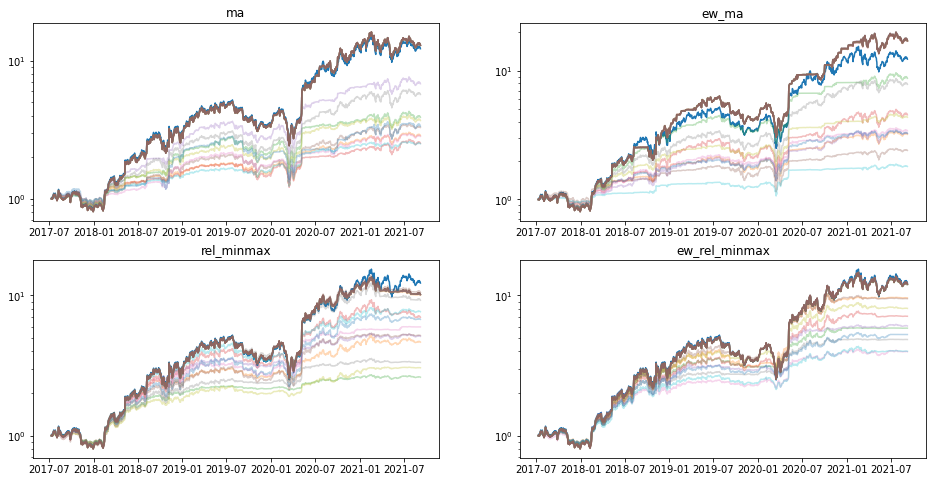

Saving TWLO params...



----------------------------------------------------------------------
                                 TWTR
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.6962681016274448
Refitting current best...
Current best ma returns: 1.9048713053833348
Fraction Invested: 0.7890747373889743
Beginning random search...
New best: 1.7863675132508565
Invested: 0.4534017269457731
Round: 10
Beginning adjusted search...
New best: 1.7950852860122022
Invested: 0.4534017269457731
New best: 1.7937257767639951
Invested: 0.45208546460498533
New best: 1.7937257767639951
Invested: 0.45208546460498533
New best: 1.7998166264344324
Invested: 0.45208546460498533
New best: 1.7997992278457144
Invested: 0.45208546460498533
New best: 1.8003497400044988
Invested: 0.45208546460498533
New best: 1.7965365016874242
Invested: 0.45208546460498533
New best: 1.798

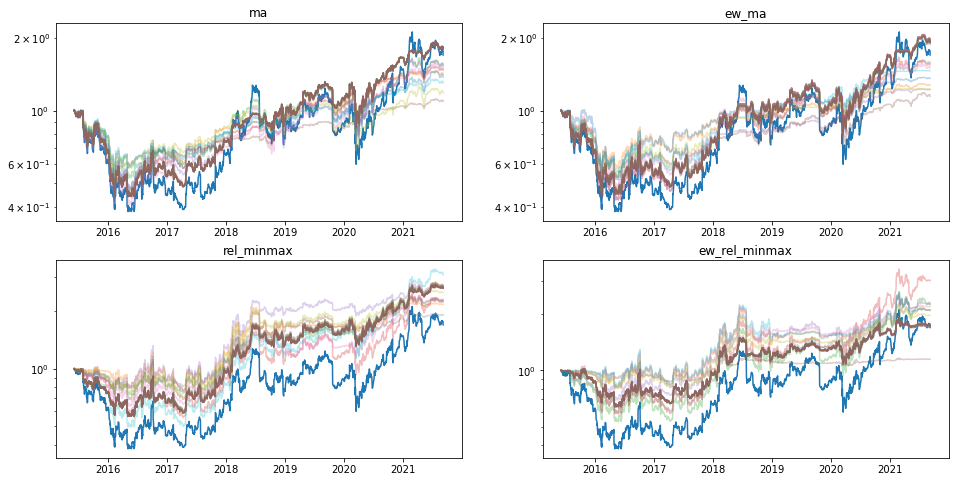

Saving TWTR params...



----------------------------------------------------------------------
                                 UPST
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.4184422002774535
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.4184422002774535
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 3.4184422002774535
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_rel_minmax method...
-------------

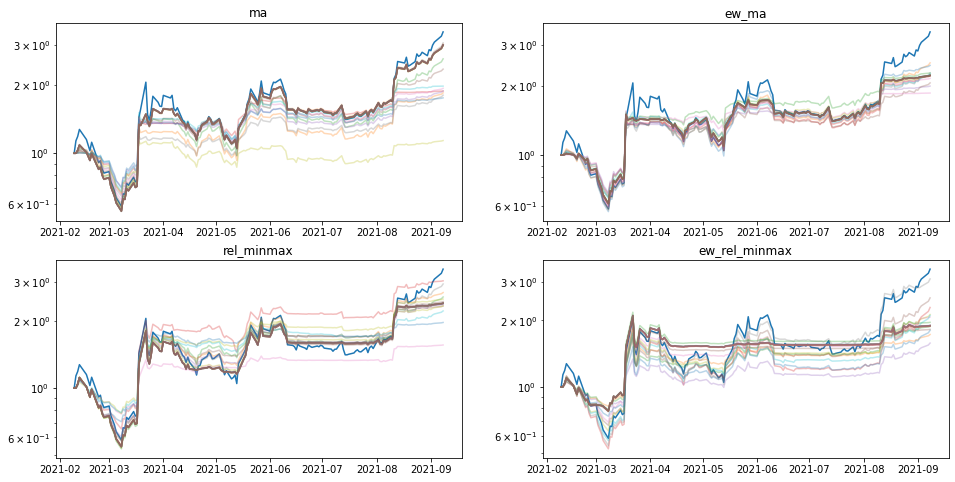

Saving UPST params...



----------------------------------------------------------------------
                                 VEEV
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 11.29595556550992
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 11.29595556550992
Refitting current best...
Current best ew_ma returns: 12.786155575704957
Fraction Invested: 0.9992774868443356
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 12.786155575704957
Invested: 0.9992774868443356
New best: 12.759486269398225
Invested: 0.9992774868443356
New best: 12.759558033232642
Invested: 0.9993205287858741
New best: 12.759558033232642
Invested: 0.9993205287858741
New best: 1

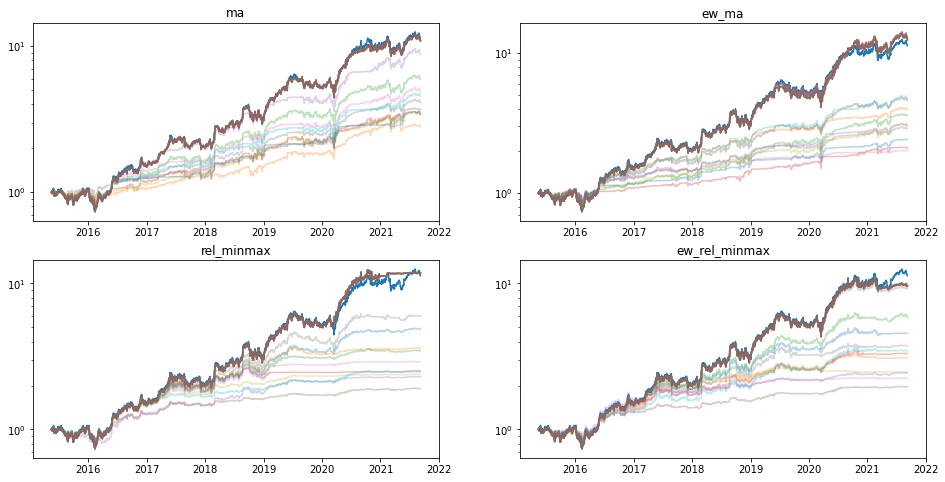

Saving VEEV params...



----------------------------------------------------------------------
                                 ZEN
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 6.1615695320414625
Refitting current best...
Current best ma returns: 6.334513947720961
Fraction Invested: 0.999132860838472
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 6.334513947720961
Invested: 0.999132860838472
New best: 6.3347561304943145
Invested: 0.999132860838472
New best: 6.337846841440603
Invested: 0.999132860838472
New best: 6.326566797528334
Invested: 0.999132860838472
New best: 6.326566797528334
Invested: 0.999132860838472
New best: 6.326537552987642
Invested: 0.999132860838472
New best: 6.326537552987642
Invested: 0.999132860838472
New best: 6.327302861039925
Invested: 0.999132860838472
New best: 6.326938595809588
Invested: 0

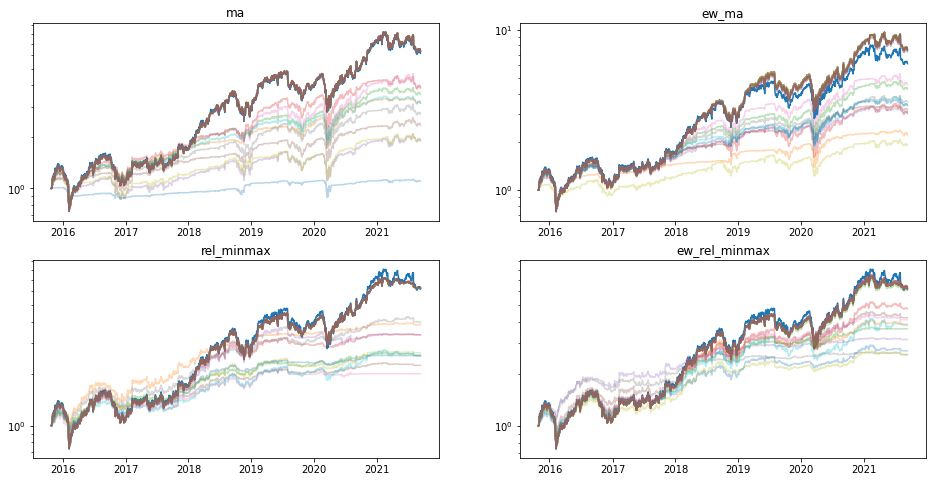

Saving ZEN params...



----------------------------------------------------------------------
                                 ZG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.095132354667688
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.095132354667688
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 4.103079620446765
Invested: 0.4578267369863382
New best: 4.128484164288221
Invested: 0.4578267369863382
New best: 4.185473267669734
Invested: 0.4578267369863382
New best: 4.185672857827064
Invested: 0.4578267369863382
New best: 4.185590046405661
Invested: 0.4578267369863382
New best: 4.1558323369694

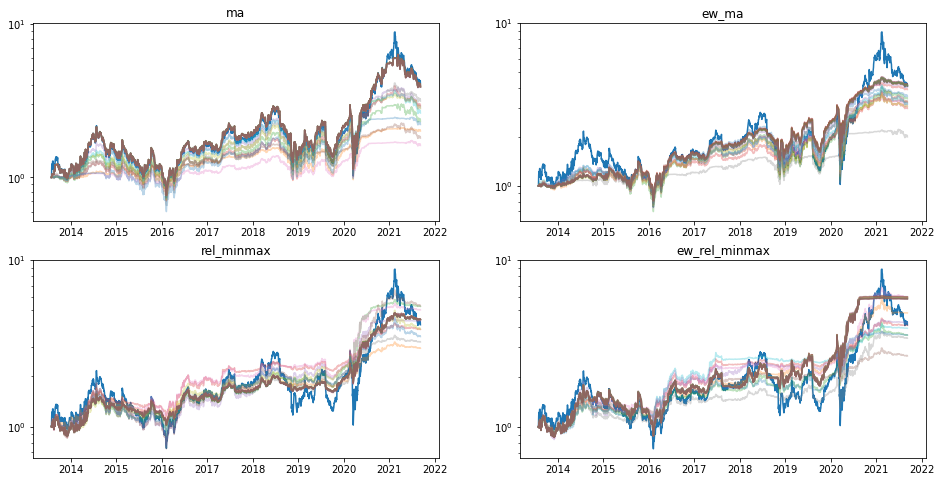

Saving ZG params...



----------------------------------------------------------------------
                                 ZNGA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.934240369186587
Refitting current best...
Current best ma returns: 2.0908636667574965
Fraction Invested: 0.9437216630282498
Beginning random search...
New best: 1.948901032586602
Invested: 0.6250235004366711
Round: 10
Beginning adjusted search...
New best: 1.9470595917257718
Invested: 0.6250235004366711
New best: 1.947101453343321
Invested: 0.6250235004366711
New best: 1.9480687816744986
Invested: 0.6250235004366711
New best: 1.9512679630942782
Invested: 0.6250235004366711
New best: 1.9512679630942782
Invested: 0.6250235004366711
New best: 1.958013192709469
Invested: 0.6250235004366711
New best: 1.971796613533206
Invested: 0.6250235004366711
New best: 1.9668085480836985

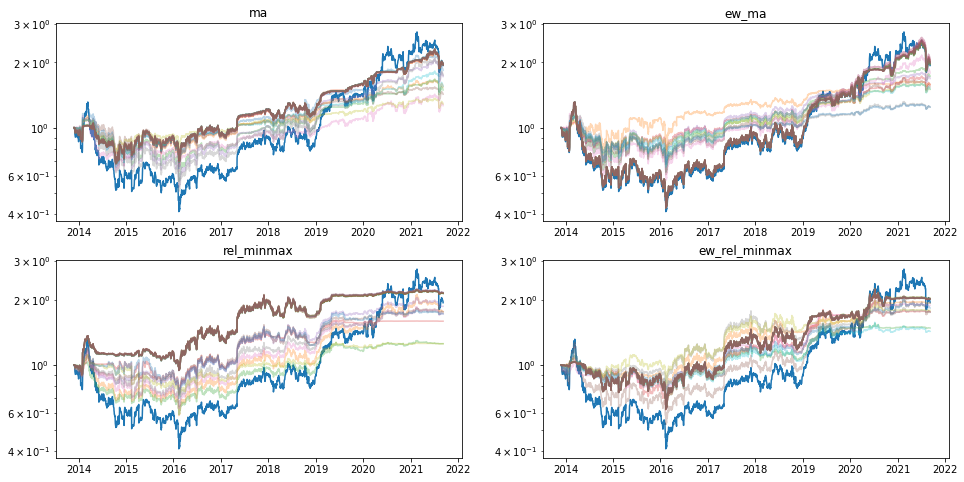

Saving ZNGA params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 36.588415737370596
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 36.588415737370596
Refitting current best...
Current best ew_ma returns: 38.07838250160478
Fraction Invested: 0.9615934827836614
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 38.09397071247131
Invested: 0.9615934827836614
New best: 38.10198378695508
Invested: 0.9615934827836614
New best: 38.104165982713106
Invested: 0.9615934827836614
New best: 38.10426215206693
Invested: 0.9615934827836614
New best: 37

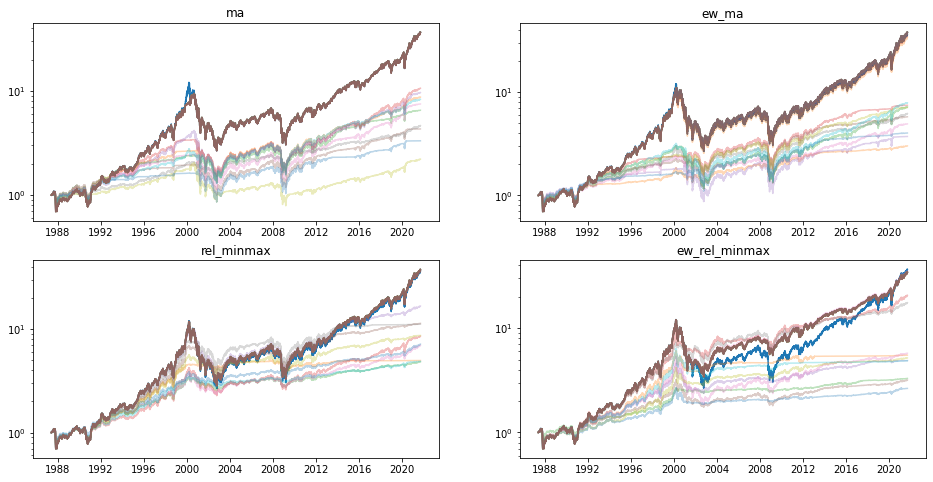

Saving ^IXIC params...


In [14]:
N_RAND = 10
N_ADJ = 15

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [15]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {100 * best_pct:.2f}% in')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [16]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)


TEAM:
  Best Return: 17.433077881738473 (ew_ma)
  3.81% in

TREX:
  Best Return: 28.67654985905391 (rel_minmax)
  19.58% in

TTD:
  Best Return: 11.93086116765172 (rel_minmax)
  14.28% in

TTWO:
  Best Return: 23.45491710597707 (ew_rel_minmax)
  30.04% in

TWLO:
  Best Return: 17.198077974864233 (ew_ma)
  99.79% in

TWTR:
  Best Return: 2.6475915706174638 (rel_minmax)
  10.29% in

UPST:
  Best Return: 3.4184422002774535 (ma)
  100.00% in

VEEV:
  Best Return: 12.481590348180674 (ew_ma)
  99.92% in

ZEN:
  Best Return: 7.301481541683542 (ew_ma)
  99.68% in

ZG:
  Best Return: 5.855593892531363 (ew_rel_minmax)
  1.80% in

ZNGA:
  Best Return: 2.1508530300455075 (rel_minmax)
  5.59% in

^IXIC:
  Best Return: 37.94545434076462 (ew_ma)
  96.16% in


In [17]:
!say qp is dunzo

IXIC: Nasdaq